In [37]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
#this is to allow you to see the plot in the notebook
%matplotlib inline 
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [38]:
CONFIG = configparser.ConfigParser()
CONFIG.read(r'/home/jchew/local/db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## The following show gaps where gap_size > 1 minute

Trying out with 3 different time range: 12am - 6am (MIDNIGHT) , 6am - 3pm (AM) , 3pm - 12 am (PM) 

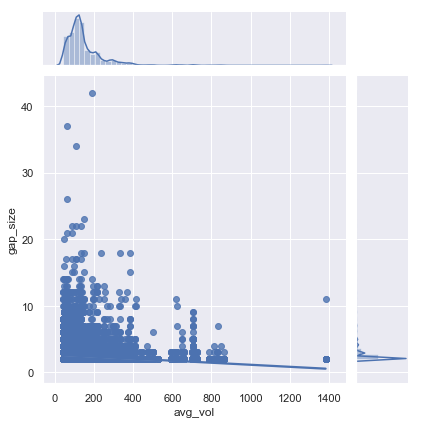

In [34]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '00:00:00'::time AND '06:00:00'::time 
    AND gap_size < 50 
    AND gap_size >0
    ''')
# removing 1 outlier here
data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

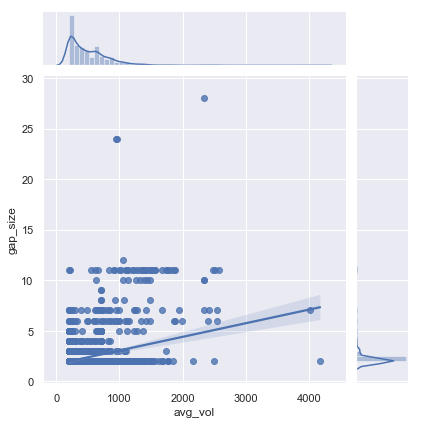

In [33]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '06:00:00'::time AND '15:00:00'::time 
    AND gap_size < 50
    AND gap_size > 0
    ''')
# removing 2 outliers here
data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

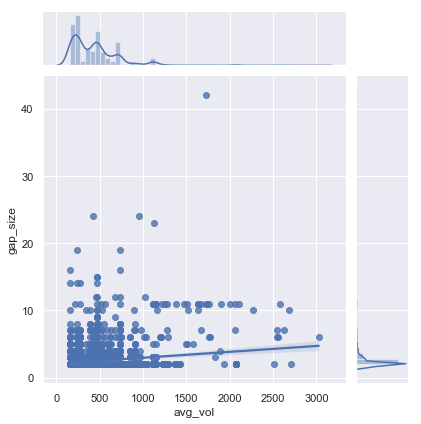

In [32]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '15:00:00'::time AND '23:00:00'::time 
    AND gap_size < 100
    AND gap_size > 0
    ''')
# removing 2 outliers here
data_5pm_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_5pm_1min)

# Testing out suggested volume-gap 

Based on the plots, suggesting the following gaps: \
volume [0,99): 20 mins \
volume [100,499): 10 mins \
volume [500,1499): 5 mins \
volume [1500,∞): 2 mins
Plotting them according to volume (instead of time) to investigate further.

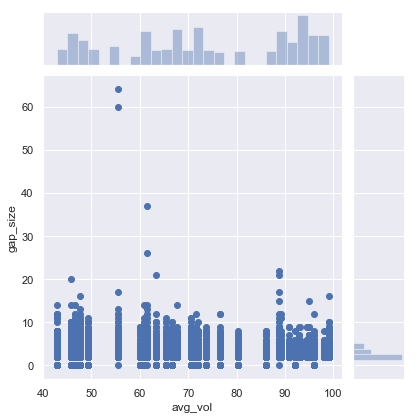

In [55]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 100
    AND gap_size < 100
    ''')
# removing 1 outlier here
data_100 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_100)

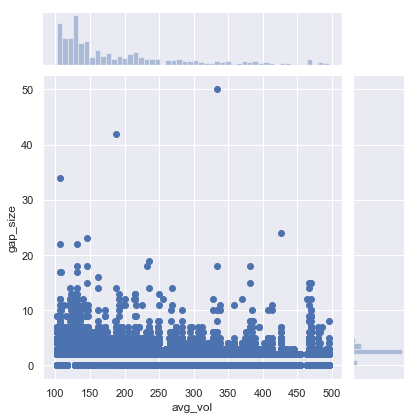

In [54]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 500
    AND avg_vol >= 100
    AND gap_size < 200
    ''')
# removing 2 outliers here
data_500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_500)

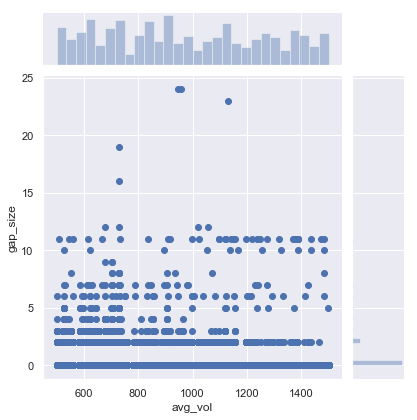

In [53]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 1500
    AND avg_vol >= 500
    AND gap_size < 150
    ''')
# removing 2 outliers here
data_1500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_1500)

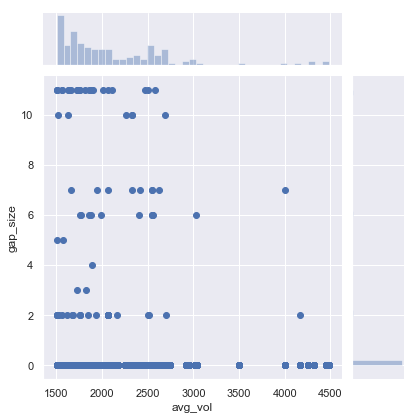

In [52]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol >= 1500
    AND gap_size < 20
    ''')
# removing 2 outliers here
data_others = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_others)